<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Bot de consulta abierta y respuestas predeterminadas con DNN + Spacy

#### Datos
Este ejemplo se inspiró en otro Bot en inglés creado con NLTK, lo tienen como referencia para hacer lo mismo en inglés:\
[LINK](https://towardsdatascience.com/a-simple-chatbot-in-python-with-deep-learning-3e8669997758)

### 1 - Instalar dependencias
Para poder utilizar Spacy en castellano es necesario agregar la librería "spacy-stanza" para lematizar palabras en español.

In [1]:
import json
import string
import random 
import numpy as np

import tensorflow as tf 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout

In [2]:
# descargaremos un pipeline de pre-procesamiento de SpaCy en español
!python -m spacy download es_core_news_sm

     ---------------------------------------- 12.9/12.9 MB 1.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [3]:
# cargar pipeline de pre-procesamiento en español
import spacy
nlp = spacy.load("es_core_news_sm")

### 2 - Herramientas de preprocesamiento de datos
Entre las tareas de procesamiento de texto en español se implementa:
- Quitar acentos y caracteres especiales
- Quitar números
- Quitar símbolos de puntuación

In [5]:
import re
import unicodedata

def preprocess_clean_text(text):    
    # sacar tildes de las palabras:
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' # [^ : ningún caracter de todos estos
    # (termina eliminando cualquier caracter distinto de los del regex)
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' # igual al anterior pero sin cifras numéricas
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntuación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

### 3 - Diccionario de entrada - Nietzsche

In [6]:
dataset = {"intents": [
             {"tag": "bienvenida",
              "patterns": ["Hola", "¿Cómo estás?", "¿Qué tal?"],
              "responses": ["Hola!", "Hola, un gusto saludarte"],
             },
             {"tag": "nacimiento",
              "patterns": ["¿Cuando nació Nietzsche?", "¿Donde nació?", "Fecha nacimiento"],
              "responses": ["Nietzsche nació el 15 de octubre de 1844, en Röcken, Prusia (actual Alemania)."],
             },
             {"tag": "vida",
              "patterns": ["¿Como fue su vida?", "¿Cuales fueron las circunstancias de su vida?", "contame sobre su vida"],
              "responses": ["Su vida estuvo marcada por períodos de salud precaria y aislamiento.", "La vida de Nietzsche fue un viaje intelectual extraordinario, marcado por su profundo pensamiento filosófico, amistades notables, y un destino trágico que dejó una huella indeleble en la historia del pensamiento occidental."],
             },
             {"tag": "influencias",
              "patterns": ["¿Cuáles fueron las principales influencias en su pensamiento?", "Influencias en su obra", "Quienes lo influenciaron?"],
              "responses": ["Sus principales influencias incluyeron a Schopenhauer, Wagner y la filología clásica."],
             },
             {"tag": "voluntad_poder",
              "patterns": ["¿Qué significa la 'voluntad de poder' en la filosofía de Nietzsche?", "voluntad de poder", "¿Que es la voluntad de poder?"],
              "responses": ["La 'voluntad de poder' se refiere al impulso fundamental que impulsa la vida.","Superación personal, afán de vida", "capacidad para reinterpretar y recrear sus propias vidas, adoptando una actitud similar a la de un artista que moldea su obra maestra."],
             },  
             {"tag": "eterno_retorno",
              "patterns": ["Explique el concepto de 'eterno retorno' de Nietzsche.", "eterno retorno", "¿Que es el eterno retorno?"],
              "responses": ["El 'eterno retorno' sugiere que todo lo que ha sucedido se repetirá infinitamente.", "debemos vivir nuestras vidas de tal manera que estemos dispuestos a experimentar y aceptar cada momento, ya que estamos destinados a repetir esos momentos eternamente.", "Es una herramienta filosófica para explorar la relación del individuo con la existencia y el significado de la vida."],
             }, 
             {"tag": "superhombre",
              "patterns": ["¿Cómo abordó Nietzsche la noción de 'superhombre' o 'Übermensch'?", "¿Que es superhombre para Nietzsche?", "Übermensch"],
              "responses": ["El 'superhombre' es una figura que trasciende los valores tradicionales y crea sus propios valores."],
             },
             {"tag": "moral_tradicional",
              "patterns": ["¿Cuál fue la crítica de Nietzsche a la moral tradicional?", "¿Qué dice sobre la moral tradicional?"],
              "responses": ["Nietzsche criticó la moral tradicional por ser esclavizante y basada en el resentimiento."],
             },
             {"tag": "obras",
              "patterns": ["¿Cuáles son algunas de las obras más conocidas de Nietzsche?", "Obras de Nietzsche", "¿Cuales son sus obras?", "obras"],
              "responses": ["Nietzsche criticó la moral tradicional por ser esclavizante y basada en el resentimiento.","Más allá del bien y del mal (Jenseits von Gut und Böse), El nacimiento de la tragedia (Die Geburt der Tragödie), Así habló Zaratustra (Also sprach Zarathustra)"],
             },
             {"tag": "agradecimientos",
              "patterns": [ "Muchas gracias", "Gracias"],
              "responses": ["Por nada!, cualquier otra consulta podes escribirme"]
             },
             {"tag": "despedida",
              "patterns": [ "Chau", "Hasta luego!"],
              "responses": ["Hasta luego!", "Hablamos luego!"]
             }
]}

### 4 - Preprocesamiento y armado del dataset

#### 4.1 Sin filtrar stop words

In [7]:
# Datos que necesitaremos, las palabras o vocabulario
words = []
classes = []
doc_X = []
doc_y = []

# Por cada intención (intents) debemos tomar los patrones que la caracterizan
# a esa intención y transformarla a tokens para almacenar en doc_X

# El tag de cada intención se almacena como doc_Y (la clase a predecir)
# En `words` vamos a guardar el vocabulario
# En `class` las posibles clases o tags

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # lematizar los tokens
        for token in tokens:            
            words.append(token.lemma_)
        
        doc_X.append(pattern)
        doc_y.append(intent["tag"])
    
    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocabulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

#### 4.2 Filtrando stop words

In [29]:
""" words = []
classes = []
doc_X = []
doc_y = []


for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        tokens_filtrados = [token for token in tokens if not token.is_stop]
        for token in tokens_filtrados:            
            words.append(token.lemma_)
        
        doc_X.append(pattern)
        doc_y.append(intent["tag"])
    
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

words = sorted(set(words))
classes = sorted(set(classes)) """

In [8]:
print("words:", words)
print("classes:", classes)
print("doc_X:", doc_X)
print("doc_y:", doc_y)

words: ['a', 'abordo', 'alguno', 'chau', 'circunstancia', 'como', 'concepto', 'conocido', 'contame', 'critica', 'cual', 'cuando', 'de', 'decir', 'donde', 'el', 'en', 'este', 'eterno', 'explicar', 'fecha', 'filosofia', 'gracia', 'gracias', 'hasta', 'holar', 'influencia', 'influenciar', 'luego', 'mas', 'moral', 'mucho', 'nacimiento', 'nacio', 'nietzschar', 'nietzsche', 'nocion', 'o', 'obra', 'para', 'pensamiento', 'poder', 'principal', 'que', 'quien', 'retorno', 'ser', 'significar', 'sobre', 'su', 'superhombre', 'tal', 'tradicional', 'ubermensch', 'vida', 'voluntad', 'él']
classes: ['agradecimientos', 'bienvenida', 'despedida', 'eterno_retorno', 'influencias', 'moral_tradicional', 'nacimiento', 'obras', 'superhombre', 'vida', 'voluntad_poder']
doc_X: ['Hola', '¿Cómo estás?', '¿Qué tal?', '¿Cuando nació Nietzsche?', '¿Donde nació?', 'Fecha nacimiento', '¿Como fue su vida?', '¿Cuales fueron las circunstancias de su vida?', 'contame sobre su vida', '¿Cuáles fueron las principales influencia

In [9]:
# Tamaño del vocabulario
print("Vocabulario:", len(words))

Vocabulario: 57


In [10]:
# Cantidad de tags
print("Tags:", len(classes))

Tags: 11


In [11]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
        text.append(token.lemma_)

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    bow = []
    for word in words:
        bow.append(1) if word in text else bow.append(0)

    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

### 5 - Entrenamiento del modelo

In [12]:
# Shape de entrada y salida
input_shape = (train_X.shape[1],)
output_shape = train_y.shape[1]
print("input:", input_shape, "output:", output_shape)

input: (57,) output: 11


In [13]:
# Entrenamiento del modelo DNN
# - Modelo secuencial
# - Con regularización
# - softmax y optimizador Adam
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation = "softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               7424      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 11)                715       
                                                                 
Total params: 16,395
Trainable params: 16,395
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
hist = model.fit(x=train_X, y=train_y, epochs=200)

Epoch 1/200
2/2 [==============================] - 1s 4ms/step - loss: 2.4333 - accuracy: 0.0882
Epoch 2/200
2/2 [==============================] - 0s 0s/step - loss: 2.5227 - accuracy: 0.0882
Epoch 3/200
2/2 [==============================] - 0s 4ms/step - loss: 2.3894 - accuracy: 0.0882
Epoch 4/200
2/2 [==============================] - 0s 4ms/step - loss: 2.3613 - accuracy: 0.2059
Epoch 5/200
2/2 [==============================] - 0s 3ms/step - loss: 2.3570 - accuracy: 0.2059
Epoch 6/200
2/2 [==============================] - 0s 4ms/step - loss: 2.3509 - accuracy: 0.1471
Epoch 7/200
2/2 [==============================] - 0s 0s/step - loss: 2.3008 - accuracy: 0.1176
Epoch 8/200
2/2 [==============================] - 0s 8ms/step - loss: 2.3565 - accuracy: 0.2059
Epoch 9/200
2/2 [==============================] - 0s 0s/step - loss: 2.3161 - accuracy: 0.1176
Epoch 10/200
2/2 [==============================] - 0s 2ms/step - loss: 2.3206 - accuracy: 0.1471
Epoch 11/200
2/2 [==============

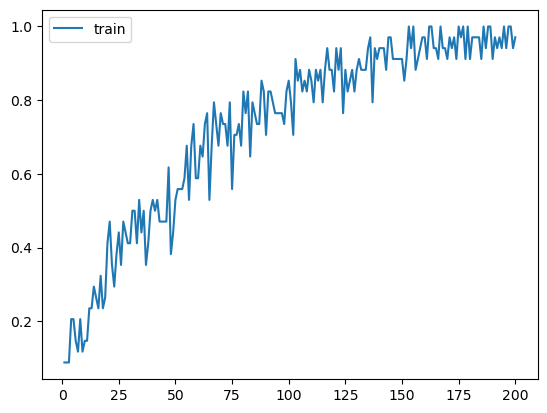

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
plt.show()

In [16]:
# Guardar lo necesario para poder re-utilizar este modelo en el futuro
# En NLP además de los modelos es necesario proveer: tokenizador y vocabulario.
# La tríada modelo+tokenizador+vocabulario es necesaria para hacer inferencia. 
# Sin una de las tres no se puede hacer inferencia.

# en este caso guardamos:
# el vocabulario utilizado (words)
# las posibles clases
# el modelo
import pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))
model.save('chatbot_model.h5')

### 6 - Testing y validación

In [17]:
# convertir texto de entrada del usuario a tokens

def text_to_tokens(text):
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    return lemma_tokens 

# Para filtrar stop words
""" def text_to_tokens(text):
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    tokens_filtrados = [token for token in tokens if not token.is_stop]
    for token in tokens_filtrados:
        lemma_tokens.append(token.lemma_)
    #print(lemma_tokens)
    return lemma_tokens """

# transformar el texto de entrada tokenizado a una representación OHE
def bag_of_words(text, vocab): 
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens: 
        for idx, word in enumerate(vocab):
            if word == w: 
                bow[idx] = 1
    #print(bow)
    return np.array(bow)

# transformar el texto de entrada tokenizado usando TF-IDF


# usar modelo con la entrada en OHE y los labels posibles (tags)
def pred_class(text, vocab, labels): 
    
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0: # sólo si reconoció alguna palabra del vocabulario
        result = model.predict(np.array([bow]))[0] # es un array de softmax
        thresh = 0.2
        # filtrar aquellas entradas menores al umbral `thresh`
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        # ordenar keys de acuerdo al valor softmax
        y_pred.sort(key=lambda x: x[1], reverse=True)
    
        # return_list es una lista de los labels de mayor a menor
        for r in y_pred:
            return_list.append(labels[r[0]])
            #print(labels[r[0]], r[1])

    # si no reconoció palabras del vocabulario se devuelve una lista vacía
    return return_list

# obtener una respuesta predeterminada 
def get_response(intents_list, intents_json):
    tag = intents_list[0] # tomar el tag con el mejor valor softmax
    list_of_intents = intents_json["intents"] # intents_json es todo el dataset
    for i in list_of_intents: 
        if i["tag"] == tag: # buscar el tag correspoindiente y dar una respuesta predeterminada aleatoria 
            result = random.choice(i["responses"])
            break
    return result

In [18]:
import keyboard
while True:
    try:
        # pedir input al usuario
        message = input("")
        print("Q:", message)
        if keyboard.is_pressed('esc'):
            print("BOT: Chau! Disfruta tu vida!")
            break
        intents = pred_class(message, words, classes)
        if len(intents) > 0:
            result = get_response(intents, dataset)
            print("BOT:", result, "\n", flush=True)
        else: # si no hubo ningún resultado que supere el umbral
            print("BOT: Perdón, no comprendo la pregunta.", "\n", flush=True)
    
        if keyboard.is_pressed('esc'):
            break
    except Exception as e:
        print(f"Error: {e}")
    

Q: hola
1/1 [==============================] - 0s 80ms/step
BOT: Hola, un gusto saludarte 

Q: cuando nació Nietzsche?
1/1 [==============================] - 0s 24ms/step
BOT: Nietzsche nació el 15 de octubre de 1844, en Röcken, Prusia (actual Alemania). 

Q: cuales fueron sus obras más importantes?
1/1 [==============================] - 0s 21ms/step
BOT: Más allá del bien y del mal (Jenseits von Gut und Böse), El nacimiento de la tragedia (Die Geburt der Tragödie), Así habló Zaratustra (Also sprach Zarathustra) 

Q: Que es el eterno retorno en su pensamiento?
1/1 [==============================] - 0s 18ms/step
BOT: El 'eterno retorno' sugiere que todo lo que ha sucedido se repetirá infinitamente. 

Q: explicame que es la voluntad de poder
1/1 [==============================] - 0s 18ms/step
BOT: La 'voluntad de poder' se refiere al impulso fundamental que impulsa la vida. 

Q: que opina sobre la moral tradicional?
1/1 [==============================] - 0s 16ms/step
BOT: Nietzsche criti

### 7 - Conclusiones
Si bien el accuracy de entrenamiento es menor al filtrar las stop words, en ambos casos el bot es capaz de responder distintos tipos de preguntas con gran precisión. Se comprobó que se obtienen mejores resultados sin filtrar las stop words.